# EpiFilter

EpiFilter assumes that $R_t$ follows a Gaussian random walk with
standard deviation at time-step $t$ equal to $\eta\sqrt{R_{t-1}}$. This
notebook:

-   Demonstrates how to fit EpiFilter with a fixed value of $\eta$
-   How to find the posterior distribution of $\eta$
-   How to marginalise out $\eta$ to present robust estimates of $R_t$
-   How to find the predictive distribution for reported cases
-   How to calculate predictive coverage and scoring rule values

All code can be found in the `/src/` folder of the [GitHub
repository](https://github.com/nicsteyn2/RobustRtEstimators). We
recommend cloning this repository and then opening `EpiFilter.ipynb` in
your preferred Jupyter notebook environment.

## Setting up

First, we need to load the necessary source code and data. We will use
data from the 2021 August outbreak of SARS-CoV-2 in Aotearoa New
Zealand. The serial interval is assumed to be gamma-distributed with
mean 6.5 days and standard deviation 4.2 days (Parag, Cowling, and
Donnelly 2021; Ferguson et al. 2020).

In [1]:
using Plots, Measures # Load package for plotting

# Ensure we are working in the root directory
# You may need to edit this for your own machine
const rootdir = @__DIR__
cd(joinpath(rootdir, ".."))

# Load source files
include("src/EpiFilter.jl")
include("src/support.jl")

# Load data
(Ct, w) = loadData("NZCOVID_AUG2021")
dates = Date("2021-08-17") .+ Day.(0:181)

# Plot
bar(dates, Ct, size=(800,400), label=false, ylabel="Reported cases", xlabel="Date", title="NZ COVID-19 cases (local transmission only)", margins=3mm, color="#f25a2a")

## Fitting default EpiFilter

We can fit the default EpiFilter model (with $\eta = 0.1$) using the
`EpiFilter(η, w, Ct)` function:

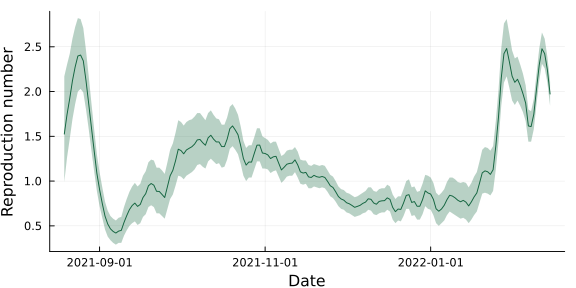

In [2]:
# Fit the model
Rgrid = LinRange(0.01, 10, 1000)
(pRt, _, _) = EpiFilterForwards(0.1, w, Ct, Rgrid)

# Extract mean and 95% credible interval
(m, med, l, u) = calculateResults(pRt, Rgrid)

# Plot output
plotR = plot(dates[3:end], m[3:end], ribbon=(m[3:end]-l[3:end], u[3:end]-m[3:end]), fillalpha=0.3, label=false, ylabel="Reproduction number", xlabel="Date", size=(600,300), color="#13643f")

Side-note: we also provide a function `EpiFilterBackwards()` which runs
the backward-smoother version of EpiFilter. As our focus is on real-time
estimation, we will not use this function in this notebook.

## Likelihood and posterior distribution for $\eta$

To find the posterior distribution of $\eta$, we run the model on a grid
of values to estimate the likelihood, and normalise with respect to a
prior distribution (in this case we use a uniform prior distribution on
$(0, 1)$). This takes approximately 1 minute on a 2021 MacBook Pro.

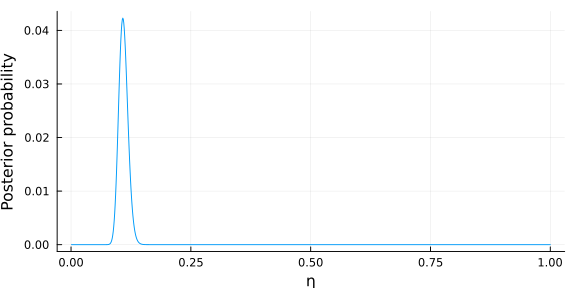

In [3]:
ηgrid = LinRange(0.001, 1, 1000) # The values of η to consider
pη0 = ones(length(ηgrid))/length(ηgrid) # A uniform prior on η
(pη, pRgivenη, pRupgivenη) = EpiFilterRunAllη(w, Ct, Rgrid, pη0, ηgrid; windin=3, showProgress=false)
plot(ηgrid, pη[:,end], label=false, xlabel="η", ylabel="Posterior probability", size=(600,300))

## Marginal posterior distribution for $R_t$

We already have all the ingredients we need to find the marginal
posterior distribution for $R_t$. We can use the
`EpiFilterMarginalPosterior()` function to do this.

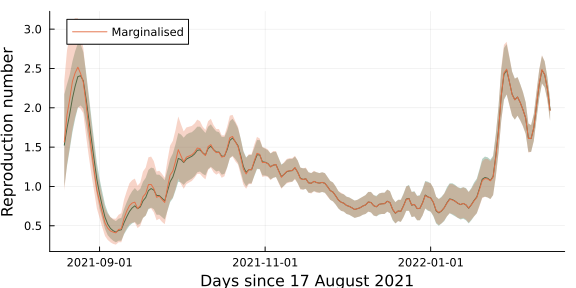

In [4]:
pR = EpiFilterMarginalPosterior(pη, pRgivenη)
(m, med, l, u) = calculateResults(pR, Rgrid)
plotR = plot!(plotR, dates[3:end], m[3:end], ribbon=(m[3:end]-l[3:end], u[3:end]-m[3:end]), fillalpha=0.3, label="Marginalised", ylabel="Reproduction number", xlabel="Days since 17 August 2021", size=(600,300))

## Predictive distributions

We also have all the ingredients required for the predictive
distributions:

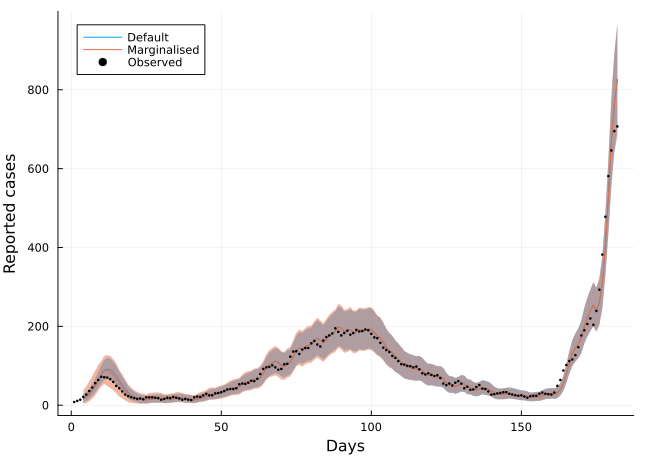

In [5]:
Cgrid = 0:(10*maximum(Ct))

# Default
pCdefault = EpiFilterConditionalPredictive(0.1, w, Ct, Rgrid, Cgrid)
(m, med, l, u) = calculateResults(pCdefault, Cgrid)
default_coverage = mean((l[4:end] .<= Ct[4:end]) .& (Ct[4:end] .<= u[4:end]))
plotCases = plot(4:length(m), m[4:end], ribbon=(m[4:end]-l[4:end], u[4:end]-m[4:end]), label="Default", ylabel="Reported cases", xlabel="Days")

# Marginalised
pC = EpiFilterMarginalPredictive(pη, pRupgivenη, w, Ct, Rgrid, Cgrid)
(m, med, l, u) = calculateResults(pC, Cgrid)
marginal_coverage = mean((l[4:end] .<= Ct[4:end]) .& (Ct[4:end] .<= u[4:end]))
plot!(plotCases, 4:length(m), m[4:end], ribbon=(m[4:end]-l[4:end], u[4:end]-m[4:end]), label="Marginalised")

# Also show the observed data
scatter!(plotCases, 1:length(Ct), Ct, label="Observed", color=:black, markersize=1.5)

## Predictive coverage and scoring rules

Calculating predictive coverage:

In [6]:
println("Predictive coverage of default EpiFilter = $(round(100*default_coverage))%")
println("Predictive coverage of marginalised EpiFilter = $(round(100*marginal_coverage))%")

Predictive coverage of default EpiFilter = 97.0%
Predictive coverage of marginalised EpiFilter = 98.0%

and the **CRPS** (lower is better) for each model:

In [7]:
include("src/scoringRules.jl")
default_crps = CRPS(cumsum(pCdefault, dims=1), Cgrid, Ct, windin=3)
marginalised_crps = CRPS(cumsum(pC, dims=1), Cgrid, Ct, windin=3)

println("CRPS of default EpiFilter = $(default_crps)")
println("CRPS of marginalised EpiFilter = $(marginalised_crps)")

CRPS of default EpiFilter = 6.765280808555216
CRPS of marginalised EpiFilter = 6.54316604914828

Ferguson, N, D Laydon, G Nedjati Gilani, N Imai, K Ainslie, M Baguelin,
S Bhatia, et al. 2020. “Report 9: Impact of Non-Pharmaceutical
Interventions (NPIs) to Reduce COVID19 Mortality and Healthcare Demand.”
Imperial College London. <https://doi.org/10.25561/77482>.

Parag, Kris V., Benjamin J. Cowling, and Christl A. Donnelly. 2021.
“Deciphering Early-Warning Signals of SARS-CoV-2 Elimination and
Resurgence from Limited Data at Multiple Scales.” *Journal of The Royal
Society Interface* 18 (185): 20210569.
<https://doi.org/10.1098/rsif.2021.0569>.